In [46]:
from pandasql import sqldf
import pandas as pd
from matplotlib import pyplot as plt, patches
import seaborn as sns
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions

In [47]:
df = pd.read_csv('DatabaseEjercicio.csv', encoding='latin-1')

In [3]:
# How many periods are considered in the data?

df['period_id'].nunique()

20

In [4]:
# Which are those periods?

df['period_id'].unique()

array([2017013, 2017014, 2017015, 2017016, 2017017, 2017018, 2017019,
       2017020, 2017021, 2017022, 2017023, 2017024, 2018013, 2018014,
       2018015, 2018016, 2018017, 2018018, 2018019, 2018020], dtype=int64)

In [48]:
# Let's build the dataframe to clasify products by it's Val_sales_converted.
# We can order this data subset by the most to the less sold item.
# For now, we're going to query the 'Inventarios_val_convertidas' column for this table, this set...
# is gonna be useful for us in the future, especially when we try to calculate the long-term storage costs. 

Query = "SELECT ItemId, Ventas_val_convertidas, Inventarios_val_convertidas FROM df WHERE period_id = '2017013' ORDER BY Ventas_val_convertidas DESC"
df_period2017013 = sqldf(Query, globals())
df_period2017013

,ItemId,Ventas_val_convertidas,Inventarios_val_convertidas
0,581160,2.656535e+09,0.0
1,581160,1.776478e+09,0.0
2,397785,1.504479e+09,0.0
3,488166,1.358940e+09,318130000.0
4,44795,1.333607e+09,0.0
...,...,...,...
58376,489402,0.000000e+00,400000.0
58377,716157,0.000000e+00,400000.0
58378,801342,0.000000e+00,250000.0
58379,74743,0.000000e+00,500000.0


In [49]:
# Total Val_sales_converted in the 2017013 period.

Ventas_val_convertidas_totales_query = "SELECT SUM(Ventas_val_convertidas) as Ventas_val_convertidas_totales FROM df_period2017013"
Ventas_val_convertidas_totales = sqldf(Ventas_val_convertidas_totales_query, globals())
Ventas_val_convertidas_totales

,Ventas_val_convertidas_totales
0,5.801460e+11


In [50]:
# Which are the distinct items sold at 2017013 period, and how many of them they are.

Items = "SELECT DISTINCT ItemId FROM df_period2017013"
UniqueItemsDf = sqldf(Items, globals())
UniqueItemsDf

,ItemId
0,581160
1,397785
2,488166
3,44795
4,397803
...,...
377,311604
378,819646
379,402836
380,154722


In [51]:
# Total Val_sales_converted by item in the 2017013 period.

Val_sales_by_item_df = pd.DataFrame()
Val_sales_by_item = []

for item in UniqueItemsDf['ItemId']:
    Val_sales_by_item_query = "SELECT SUM(Ventas_val_convertidas) as Ventas_val_convertidas_totales FROM df_period2017013 WHERE ItemId = '{}'".format(str(item))
    Val_sales_by_item.append(sqldf(Val_sales_by_item_query, globals())['Ventas_val_convertidas_totales'][0])

Val_sales_by_item_df['ItemId'] = UniqueItemsDf['ItemId']
Val_sales_by_item_df['Ventas_val_convertidas_totales'] = Val_sales_by_item

Val_sales_by_item_df
    

,ItemId,Ventas_val_convertidas_totales
0,581160,5.874922e+10
1,397785,2.881806e+10
2,488166,2.404102e+10
3,44795,3.127160e+10
4,397803,1.149117e+10
...,...,...
377,311604,0.000000e+00
378,819646,0.000000e+00
379,402836,0.000000e+00
380,154722,0.000000e+00


In [52]:
# Identify the zeroes in the "Val_converted_sales".
# This could be useful to know this to calculate the inventory costs by this items.

Val_sales_by_item_query_zeroes = "SELECT ItemId, Ventas_val_convertidas_totales FROM Val_sales_by_item_df WHERE Ventas_val_convertidas_totales = 0"
Val_sales_by_item_df_zeroes = sqldf(Val_sales_by_item_query_zeroes, globals())

print("These are the colection of products that got no sales in the 2017013 period, there's a total of {} products:".format(Val_sales_by_item_df_zeroes['ItemId'].count()))
Val_sales_by_item_df_zeroes

These are the colection of products that got no sales in the 2017013 period, there's a total of 25 products:


,ItemId,Ventas_val_convertidas_totales
0,730759,0.0
1,460628,0.0
2,374242,0.0
3,838470,0.0
4,374262,0.0
5,34074,0.0
6,299975,0.0
7,402833,0.0
8,8800,0.0
9,20973,0.0


In [62]:
# The range of the ItemId column in order to plot the histogram of Val_sales_converted by item.

range_lenght = Val_sales_by_item_df['ItemId'].max() - Val_sales_by_item_df['ItemId'].min()
print(range_lenght)

916851


<AxesSubplot:>

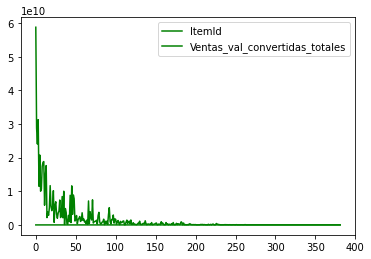

In [63]:
# Let's see how the valoration of converted sales are distributed among items...

Val_sales_by_item_df.plot(color="green")

In [64]:
# As shown in the plot above, there's a few selection of products represents the largest amount of converted sales.
# Which is the product that represents the most of sales, and how much generate?
# How much percentage of the total sales this one represents?


Max_sales = Val_sales_by_item_df['Ventas_val_convertidas_totales'].max()
print('The Top sales item, represents a total sales of {}'.format(Max_sales))

percentage = ((Val_sales_by_item_df['Ventas_val_convertidas_totales'].max()/5.801460e+11)*100).round(2)
print('\nThis is equivalent to a {}% of the sales generated in the 2017013 period'.format(percentage))

print('\nThis item corresponds to:')
Val_sales_by_item_df.loc[Val_sales_by_item_df['Ventas_val_convertidas_totales'] == Max_sales]

The Top sales item, represents a total sales of 58749216713.0

This is equivalent to a 10.13% of the sales generated in the 2017013 period

This item corresponds to:


,ItemId,Ventas_val_convertidas_totales
0,581160,5.874922e+10


The first 250 most sold items in the 2017013 period, represents the 99.89% of the total valoration of converted sales


Text(100, 30000000000.0, 'A total of 132 products, just represent the 0.11% of valoration sales')

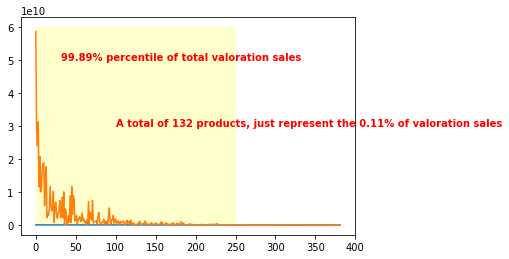

In [65]:
# As shown in the plot of the converted val_sales, by eye we could suspect that more than 90% of the sales comes from the first
# 250 products (remember this list is ordered by descending sales). Let's calculate how much percentage this 250 items
# represents in sales...

Val_sales_by_item_query_limit250_query = "SELECT ItemId, Ventas_val_convertidas_totales FROM Val_sales_by_item_df LIMIT 250"
Val_sales_by_item_query_limit250 = sqldf(Val_sales_by_item_query_limit250_query, globals())

percentage_limit250 = (Val_sales_by_item_query_limit250['Ventas_val_convertidas_totales'].sum()/5.801460e+11)*100
print("The first 250 most sold items in the 2017013 period, represents the {}% of the total valoration of converted sales".format(percentage_limit250.round(2)))

Val_sales_by_item_query_limit250

rect = patches.Rectangle((0, 0), 250, 6e10, alpha = 0.2, facecolor="yellow", linewidth=7)
plt.plot(Val_sales_by_item_df)
plt.gca().add_patch(rect)
plt.text(31, 5e10,'99.89% percentile of total valoration sales',fontsize=10, color="red", weight="bold")
plt.text(100, 3e10,'A total of 132 products, just represent the 0.11% of valoration sales',fontsize=10, color="red", weight="bold")


In [69]:
# Let's calculate how much, in money, represents that 0.11%...

money_from_the_bottom_132 = Ventas_val_convertidas_totales['Ventas_val_convertidas_totales'][0]*0.0011
print("Money that comes from the bottom 132 items those who sold in 2017013 period, represent in money a total of {} colombian pesos".format(money_from_the_bottom_132))

# Now, we need to compare that income with the inventory costs which that selection represents...

first_382_naturals = []
i = 0
while i < 382:
    first_382_naturals.append(i)
    i += 1
# My range() function broke for a reason this prompt a 'numpyint64-object-is-not-callable error' when I try a for loop with range()

Val_sales_by_item_df['serial_item_id'] = first_382_naturals
bottom_132_query =  "SELECT serial_item_id, ItemId, Ventas_val_convertidas_totales FROM Val_sales_by_item_df WHERE serial_item_id >= 250"
bottom_132_table = sqldf(bottom_132_query, globals())
bottom_132_table

Money that comes from the bottom 132 items those who sold in 2017013 period, represent in money a total of 638160588.2325426 colombian pesos


,serial_item_id,ItemId,Ventas_val_convertidas_totales
0,250,165969,10410000.0
1,251,397804,81743000.0
2,252,760355,15560000.0
3,253,158335,8050000.0
4,254,176031,6290000.0
...,...,...,...
127,377,311604,0.0
128,378,819646,0.0
129,379,402836,0.0
130,380,154722,0.0


In [70]:
# Now, we need add to the table above, the column that displays the TOTAL valoration of converted inventory, for this, we're...
# going to use the same code to get the Total Val_sales_converted.

# Instead to use the 'UniqueItemsDf' that we extract from df_period2017013, we must use the column of 'ItemId' from the...
# bottom_132_table.

# Be aware, bottom_132_table['ItemId'] is a data SERIES, rather than an sqldf, which is the type of data that we need.
UniqueItemsBottom132_query = "SELECT ItemId FROM bottom_132_table"
UniqueItemsBottom132 = sqldf(UniqueItemsBottom132_query, globals())

Val_inventories_by_item_df = pd.DataFrame()
Val_inventories_by_item = []

for item in UniqueItemsBottom132['ItemId']:
    Val_inventories_by_item_query = "SELECT SUM(Inventarios_val_convertidas) as Inventarios_val_convertidos_totales FROM df_period2017013 WHERE ItemId = '{}'".format(str(item))
    Val_inventories_by_item.append(sqldf(Val_inventories_by_item_query, globals())['Inventarios_val_convertidos_totales'][0])

Val_inventories_by_item_df['ItemId'] = UniqueItemsBottom132['ItemId']
Val_inventories_by_item_df['Inventarios_val_convertidos_totales'] = Val_inventories_by_item

# Obtaining the total storage costs...
Storage_costs = Val_inventories_by_item_df['Inventarios_val_convertidos_totales'].sum()
print("\nThe total storage costs sum in total, for the 2017013 period, a total of {}...".format(Storage_costs))
netCosts = Storage_costs - money_from_the_bottom_132
print("Making a compensation with the sales made by this items in the period, this represent a net cost of {}".format(netCosts))

# Printing the needed table...
Val_inventories_by_item_df


The total storage costs sum in total, for the 2017013 period, a total of 1855879810.0...
Making a compensation with the sales made by this items in the period, this represent a net cost of 1217719221.7674575


,ItemId,Inventarios_val_convertidos_totales
0,165969,14303501.0
1,397804,117160000.0
2,760355,20690000.0
3,158335,2960000.0
4,176031,380000.0
...,...,...
127,311604,39240000.0
128,819646,600000.0
129,402836,4800000.0
130,154722,880000.0


In [71]:
Times = netCosts/money_from_the_bottom_132
print("\nNet costs represent {} times the income from the less sold 132 products in the 2017013".format(Times.round(2)))


Net costs represent 1.91 times the income from the less sold 132 products in the 2017013


In [72]:
# As we see, the company spends more by storing these items. May be could be a good idea to cut inventories of those products...
# that generates those costs, if this behavior persists for some of them in other periods frequently.

# Now we want to know, how the sales are distributed by cities and recognize if a larger percentile of converted sales are...
# concentrated in a few of them.
# To acomplish this we need modify a little bit our df_period2017013 dataframe, we need the same but with the 'areacig_name'...
# instead of the inventories one. Let's build it, remember, we're examining the 2017013 period, all this analysis can
# be extrapolated to other periods...

Query_cities = "SELECT DISTINCT areacig_name as ciudad FROM df WHERE period_id = '2017013'"
df_cities_period2017013 = sqldf(Query_cities, globals())

Query = "SELECT areacig_name as ciudad, Ventas_val_convertidas FROM df WHERE period_id = '2017013' ORDER BY Ventas_val_convertidas DESC"
df_period2017013_salesbycity = sqldf(Query, globals())

# These are our unique cities for 2017013.
df_cities_period2017013

,ciudad
0,Barranquilla
1,Resto Costa
2,Cartagena
3,Valledupar
4,Santa Marta
5,Montería
6,Sincelejo
7,Resto Cartagena
8,Cali
9,Medellín Capital


In [73]:
# And here there is the table by which we're gonna sum up the sales that generate each city by every sale made in 2017013.

df_period2017013_salesbycity

,ciudad,Ventas_val_convertidas
0,Medellín Capital,2.656535e+09
1,Bogotá,1.776478e+09
2,Medellín Capital,1.504479e+09
3,Cali,1.358940e+09
4,Medellín Capital,1.333607e+09
...,...,...
58376,Villavicencio,0.000000e+00
58377,Villavicencio,0.000000e+00
58378,Villavicencio,0.000000e+00
58379,Bogotá,0.000000e+00


In [74]:
Val_by_city_df = pd.DataFrame()
Val_by_city = []

for city in df_cities_period2017013['ciudad']:
    Val_by_city_query = "SELECT SUM(Ventas_val_convertidas) as Ventas_val_convertidas_totales_por_ciudad FROM df_period2017013_salesbycity WHERE ciudad = '{}'".format(str(city))
    Val_by_city.append(sqldf(Val_by_city_query, globals())['Ventas_val_convertidas_totales_por_ciudad'][0])

Val_by_city_df['ciudad'] = df_cities_period2017013['ciudad']
Val_by_city_df['Ventas_val_convertidas_totales_por_ciudad'] = Val_by_city

Val_by_city_df

,ciudad,Ventas_val_convertidas_totales_por_ciudad
0,Barranquilla,2.508866e+10
1,Resto Costa,5.927160e+09
2,Cartagena,2.317607e+10
3,Valledupar,3.564577e+09
4,Santa Marta,8.188055e+09
5,Montería,3.859798e+09
6,Sincelejo,2.864849e+09
7,Resto Cartagena,1.658384e+09
8,Cali,5.431323e+10
9,Medellín Capital,7.124666e+10


In [76]:
# Then, we need to order this data by the largest to the lowest size of sale...

ordering = "SELECT ciudad, Ventas_val_convertidas_totales_por_ciudad FROM Val_by_city_df ORDER BY Ventas_val_convertidas_totales_por_ciudad DESC"
Val_by_city_df_inOrder = sqldf(ordering, globals())

Val_by_city_df_inOrder

,ciudad,Ventas_val_convertidas_totales_por_ciudad
0,Bogotá,1.918603e+11
1,Medellín Capital,7.124666e+10
2,Cali,5.431323e+10
3,Manizales,2.932335e+10
4,Barranquilla,2.508866e+10
5,Cartagena,2.317607e+10
6,Resto Medellin,2.248690e+10
7,Pereira,1.775071e+10
8,Resto Cundinamarca,1.718557e+10
9,Bucaramanga,1.387392e+10


<AxesSubplot:>

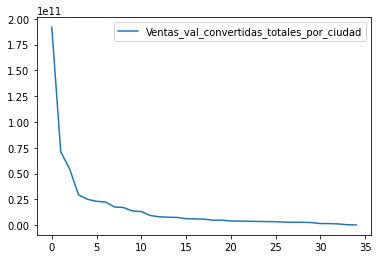

In [77]:
# Now, lets see how the amount of sales distributes among cities...

Val_by_city_df_inOrder.plot()

{'lognorm': {'s': 1.3260473686166498,
  'loc': 56030403.50325867,
  'scale': 6433131211.235846}}

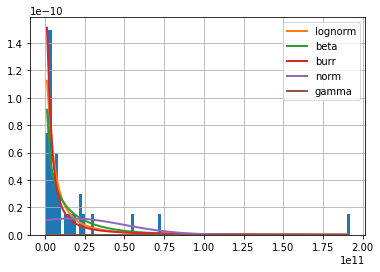

In [103]:
# Apparently the graph above corresponds to a beta distribution, let's be sure of that using the distributions
# database of scipy...

Val_sales_by_city_y = Val_by_city_df_inOrder["Ventas_val_convertidas_totales_por_ciudad"].values
f = Fitter(Val_sales_by_city_y,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()
f.get_best(method = 'sumsquare_error')

# Usually lognorm distribution fits in process that aren't size dependent.
# Like a plant that grew a fixed amount each day, or a plant that slowed down after reaching some height threshold, would be *dependent* 
# on the absolute size, and so we would not expect a log-normal distribution...
# So, this means essentially that the growth size rate of the entrepreneurship of cigarette industry is the same...
# independly which city size you choose to start...
# This could be key, if you expect a x% return on your capital, depending on the size of your money...
# If you got 2 billion to invest, but the economy of a city is just 1 billion, there's no good idea to begin there...
# better to choose a larger city with the confidence that you're gonna expect the same return.

In [80]:
# We can do this study, using brands and makers.
# Usually, makers have a huge selection of products that could be the preference of the clients or not...
# So, may be it's a good a idea to start with brands.
# We're going to make this study considering the whole periods (we're just measuring the preference of brands, over time)

Query_brands = "SELECT DISTINCT marca FROM df"
df_brands = sqldf(Query_brands, globals())

Query_brands_vs_sales = "SELECT marca, Ventas_val_convertidas FROM df ORDER BY Ventas_val_convertidas DESC"
df_salesbybrand = sqldf(Query_brands_vs_sales, globals())

# These are our unique brands.
df_brands

,Marca
0,MARLBORO ...
1,BELMONT ...
2,GREEN ...
3,BOSTON ...
4,LUCKY STRIKE ...
5,CHESTERFIELD ...
6,PREMIER ...
7,PALL MALL ...
8,FORTUNA ...
9,MUSTANG ...


In [81]:
# And here there is the table by which we're gonna sum up the sales that generate each brand by every sale made among...
# the whole periods...

df_salesbybrand

,Marca,Ventas_val_convertidas
0,MUSTANG ...,3.174186e+10
1,ROTHMANS ...,3.088462e+10
2,ROTHMANS ...,3.085236e+10
3,ROTHMANS ...,2.930940e+10
4,ROTHMANS ...,2.399475e+10
...,...,...
1048570,MARLBORO ...,0.000000e+00
1048571,MARLBORO ...,0.000000e+00
1048572,WINSTON ...,0.000000e+00
1048573,MARLBORO ...,0.000000e+00


In [82]:
# Now let's sum all the converted sales by brand...
# This is going to take a while, there's a total of ~ 1M rows...

Val_by_brand_df = pd.DataFrame()
Val_by_brand = []

for brand in df_brands['Marca']:
    Val_by_brand_query = "SELECT SUM(Ventas_val_convertidas) as Ventas_val_convertidas_totales_por_marca FROM df_salesbybrand WHERE Marca = '{}'".format(str(brand))
    Val_by_brand.append(sqldf(Val_by_brand_query, globals())['Ventas_val_convertidas_totales_por_marca'][0])

Val_by_brand_df['Marca'] = df_brands['Marca']
Val_by_brand_df['Ventas_val_convertidas_totales_por_marca'] = Val_by_brand

Val_by_brand_df

,Marca,Ventas_val_convertidas_totales_por_marca
0,MARLBORO ...,4.496346e+12
1,BELMONT ...,2.497518e+11
2,GREEN ...,1.953178e+10
3,BOSTON ...,6.130177e+11
4,LUCKY STRIKE ...,1.609596e+12
5,CHESTERFIELD ...,9.774361e+11
6,PREMIER ...,1.005995e+11
7,PALL MALL ...,2.291848e+10
8,FORTUNA ...,2.964902e+10
9,MUSTANG ...,6.481855e+11


In [83]:
# Remember to order the data by descending order...

ordering_brands = "SELECT Marca, Ventas_val_convertidas_totales_por_marca FROM Val_by_brand_df ORDER BY Ventas_val_convertidas_totales_por_marca DESC"
Val_by_brands_df_inOrder = sqldf(ordering_brands, globals())

Val_by_brands_df_inOrder

,Marca,Ventas_val_convertidas_totales_por_marca
0,MARLBORO ...,4.496346e+12
1,ROTHMANS ...,1.880385e+12
2,LUCKY STRIKE ...,1.609596e+12
3,CHESTERFIELD ...,9.774361e+11
4,MUSTANG ...,6.481855e+11
5,BOSTON ...,6.130177e+11
6,L&M ...,4.990171e+11
7,DERBY ...,4.440448e+11
8,BELMONT ...,2.497518e+11
9,STARLITE ...,1.250252e+11


<AxesSubplot:>

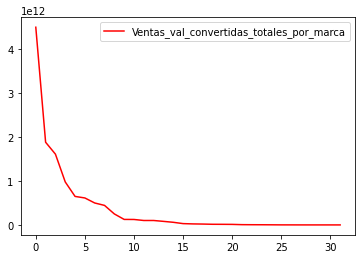

In [84]:
# Lets take a look of sales distribution among brands...

Val_by_brands_df_inOrder.plot(color="red")

<AxesSubplot:ylabel='Ventas_val_convertidas_totales_por_marca'>

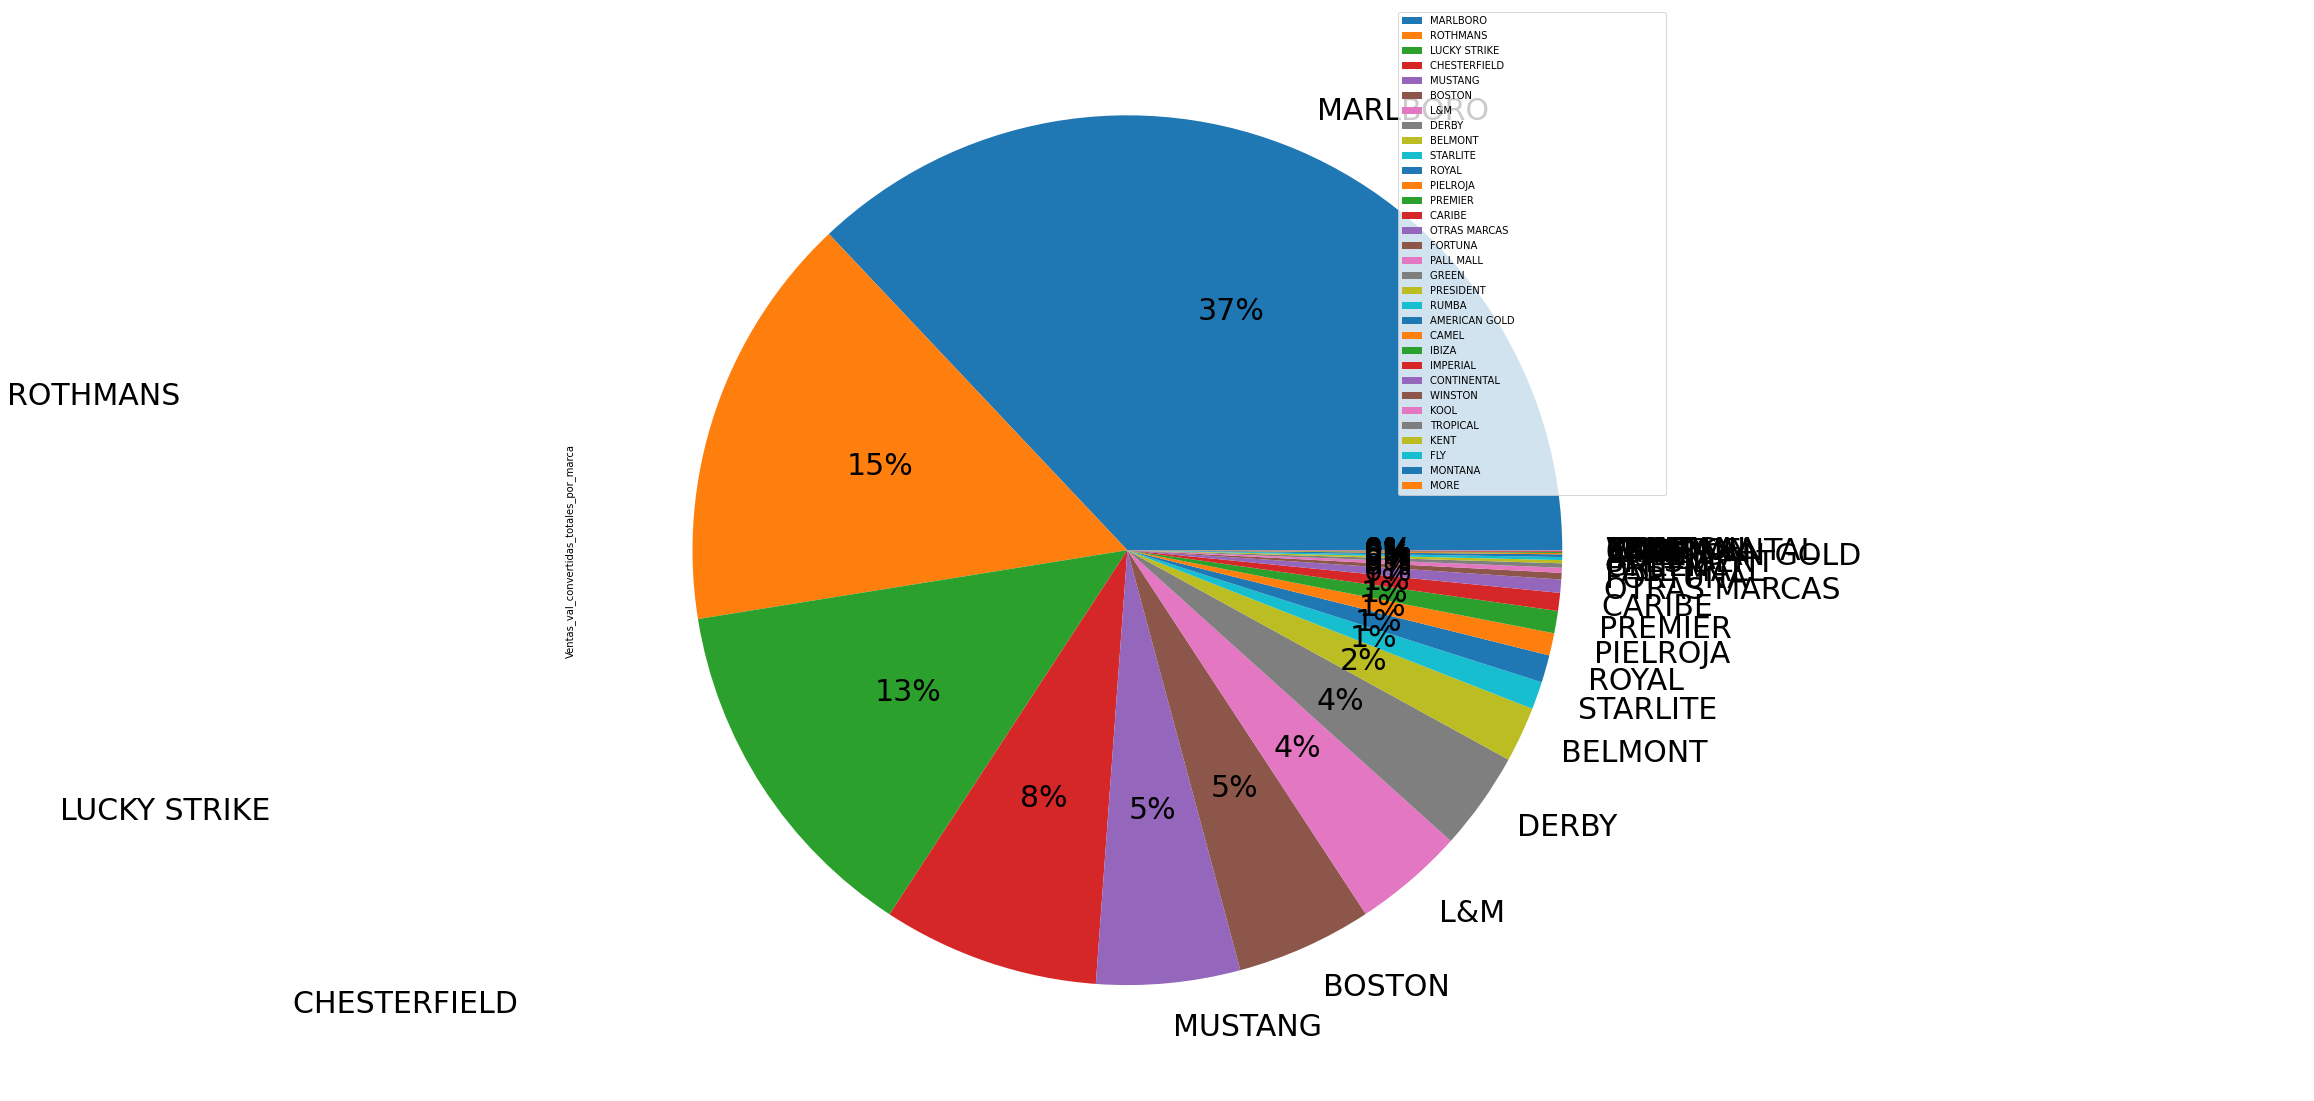

In [87]:
Val_by_brands_df_inOrder.plot.pie(y='Ventas_val_convertidas_totales_por_marca', labels=Val_by_brands_df_inOrder['Marca'], fontsize=30, autopct='%1.0f%%', figsize=(20, 20))

In [88]:
# There's 1 brand or sub-selection of brands that convert nothing in the whole periods this correspons to...

worst_brand_query = "SELECT Marca FROM Val_by_brands_df_inOrder WHERE Ventas_val_convertidas_totales_por_marca = 0"
worst_brand = sqldf(worst_brand_query, globals())

worst_brand

,Marca
0,MORE ...


In [89]:
# We've may identify where's the main source of items that are causing the most loses. The study is suggesting that we need...
# to focus in one sub-selection of providers...

# Now, lets see if we can find the main source of kind of stores that these sales are coming from...

Query_kind_stores = "SELECT DISTINCT tipo_de_tienda_name FROM df"
df_kind_stores = sqldf(Query_kind_stores, globals())

Query_stores_vs_sales = "SELECT tipo_de_tienda_name as tipo_de_tienda, Ventas_val_convertidas FROM df ORDER BY Ventas_val_convertidas DESC"
df_salesbystore = sqldf(Query_stores_vs_sales, globals())

# These are our unique kind of stores.
df_kind_stores

,tipo_de_tienda_name
0,Super Gde.
1,Tradicionales
2,Bares
3,Panaderías
4,Cafeterias
5,Cajoneros
6,Licorerias
7,Restaurantes
8,Kioscos
9,Minimercados


In [90]:
# This is our sales tracking comparing the converted sales in each event and it's associated store...

df_salesbystore

,tipo_de_tienda,Ventas_val_convertidas
0,Super Gde.,3.174186e+10
1,Super Gde.,3.088462e+10
2,Super Gde.,3.085236e+10
3,Super Gde.,2.930940e+10
4,Super Gde.,2.399475e+10
...,...,...
1048570,Kioscos,0.000000e+00
1048571,Kioscos,0.000000e+00
1048572,Tradicionales,0.000000e+00
1048573,Tradicionales,0.000000e+00


In [91]:
Val_by_storeKind_df = pd.DataFrame()
Val_by_storeKind = []

for store in df_kind_stores['tipo_de_tienda_name']:
    Val_by_storeKind_query = "SELECT SUM(Ventas_val_convertidas) as Ventas_val_convertidas_totales_por_tipo_tienda FROM df_salesbystore WHERE tipo_de_tienda = '{}'".format(str(store))
    Val_by_storeKind.append(sqldf(Val_by_storeKind_query, globals())['Ventas_val_convertidas_totales_por_tipo_tienda'][0])

Val_by_storeKind_df['tipo_de_tienda'] = df_kind_stores['tipo_de_tienda_name']
Val_by_storeKind_df['Ventas_val_convertidas_totales_por_tipo_tienda'] = Val_by_storeKind

Val_by_storeKind_df

,tipo_de_tienda,Ventas_val_convertidas_totales_por_tipo_tienda
0,Super Gde.,9.376325e+12
1,Tradicionales,1.221666e+12
2,Bares,1.639858e+11
3,Panaderías,9.647116e+10
4,Cafeterias,1.496457e+11
5,Cajoneros,1.792541e+11
6,Licorerias,4.201651e+11
7,Restaurantes,5.929079e+10
8,Kioscos,1.494267e+11
9,Minimercados,3.227112e+11


In [92]:
# We order in descending order...

ordering_storesKind = "SELECT tipo_de_tienda, Ventas_val_convertidas_totales_por_tipo_tienda FROM Val_by_storeKind_df ORDER BY Ventas_val_convertidas_totales_por_tipo_tienda DESC"
Val_by_storesKind_df_inOrder = sqldf(ordering_storesKind, globals())

Val_by_storesKind_df_inOrder

,tipo_de_tienda,Ventas_val_convertidas_totales_por_tipo_tienda
0,Super Gde.,9.376325e+12
1,Tradicionales,1.221666e+12
2,Licorerias,4.201651e+11
3,Minimercados,3.227112e+11
4,Cajoneros,1.792541e+11
5,Bares,1.639858e+11
6,Cafeterias,1.496457e+11
7,Kioscos,1.494267e+11
8,Panaderías,9.647116e+10
9,Restaurantes,5.929079e+10


<AxesSubplot:ylabel='Ventas_val_convertidas_totales_por_tipo_tienda'>

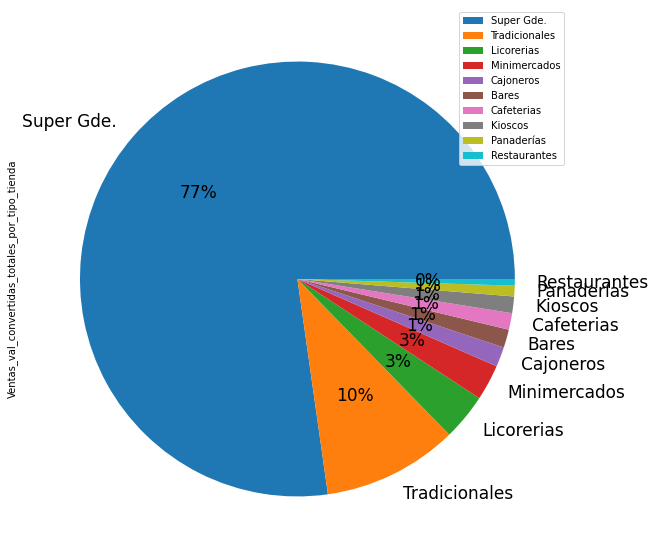

In [93]:
Val_by_storesKind_df_inOrder.plot.pie(y='Ventas_val_convertidas_totales_por_tipo_tienda', labels=Val_by_storesKind_df_inOrder['tipo_de_tienda'], fontsize=17, autopct='%1.0f%%', figsize=(10, 10))

In [94]:
# Looks like the big supermarkets and tiny traditional stores are the main sources of convertions, this, combined with what...
# we already now about the beta distribution of the cigarrete sale business, we know that likelihood to expand succesfully...
# to another areas inside Colombia is by focusing in the distribution in these kind of stores.

In [95]:
# Finally to conclude this brief study as excersize I want to know the meaning some parameters in this database that are beyond
# ... the scope here, due to time ｡ﾟ(ﾟ∩´﹏`∩ﾟ)ﾟ

# Apparently, taking an small sample of cases, the parameter named 'x_factor', is the factor to estimate future volumen of
# sales by using the volumen of sales converted in a particular sale.

# So... the formula is Vol_sales_projected = x_factor * Vol_sales_converted.

# Let's test this hypotesis iterating over our dataframe...

querying_xfactor = "SELECT x_factor, Ventas_vol_convertidas, Ventas_vol_proyectadas FROM df"
xfactor_table = sqldf(querying_xfactor, globals())

xfactor_table

,x_factor,Ventas_vol_convertidas,Ventas_vol_proyectadas
0,1.0,100,100.0
1,1.0,20,20.0
2,1.0,200,200.0
3,1.0,200,200.0
4,1.0,120,120.0
...,...,...,...
1048570,1.0,400,400.0
1048571,1.0,200,200.0
1048572,1.0,700,700.0
1048573,1.0,100,100.0


In [96]:
query_to_test = "SELECT x_factor, Ventas_vol_convertidas, Ventas_vol_proyectadas, x_factor*Ventas_vol_convertidas AS Ventas_vol_proyectadas_by_formula FROM xfactor_table"
test = sqldf(query_to_test, globals())

query_to_test_boolean = "SELECT *, (Ventas_vol_proyectadas_by_formula - Ventas_vol_proyectadas) AS test_value FROM test WHERE test_value > 0.001"

# We need to use this special query, because, due to the float calculation in 'Ventas_vol_proyectadas_by_formula'...
# if we use 'Ventas_vol_proyectadas_by_formula != Ventas_vol_proyectadas', our query gonna detect differences is...
# many of the values, when essentially are the same, try by your own if this is not clear...
# try with: "SELECT *, (Ventas_vol_proyectadas_by_formula - Ventas_vol_proyectadas) AS test_value FROM test WHERE test_value != 0"

test_boolean = sqldf(query_to_test_boolean, globals())

test_boolean # If our hypotesis is correct, this query should prompt an empty table.

,x_factor,Ventas_vol_convertidas,Ventas_vol_proyectadas,Ventas_vol_proyectadas_by_formula,test_value


In [97]:
# There's a last parameter to analyse to understand our data...
# Each "Unit_sales" are "packages" or sets of products that is given by the "Convertion_factor".
# The formula is: Vol_sales_converted = Unit_sales*Convertion_factor...
# Let's see if it's true...

querying_UnitSales = "SELECT Ventas_unidad, Factor_de_conversion, Ventas_val_convertidas FROM df"
UnitSales_table = sqldf(querying_UnitSales, globals())

UnitSales_table

,Ventas_unidad,Factor_de_conversion,Ventas_val_convertidas
0,1,100,2200000.0
1,2,10,289400.0
2,1,200,4000000.0
3,2,100,4000000.0
4,12,10,1740000.0
...,...,...,...
1048570,2,200,9400000.0
1048571,1,200,2350000.0
1048572,7,100,35000000.0
1048573,1,100,2500000.0


In [99]:
query_to_test2 = "SELECT Ventas_unidad, Factor_de_conversion, Ventas_val_convertidas, Ventas_unidad*Factor_de_conversion AS Ventas_val_convertidas_by_formula FROM UnitSales_table"
test2 = sqldf(query_to_test2, globals())

query_to_test_boolean2 = "SELECT *, (Ventas_val_convertidas_by_formula - Ventas_val_convertidas) AS test_value FROM test2 WHERE test_value > 0.001"
test_boolean2 = sqldf(query_to_test_boolean2, globals())
test_boolean2

,Ventas_unidad,Factor_de_conversion,Ventas_val_convertidas,Ventas_val_convertidas_by_formula,test_value
0,3,200,300.0,600,300.0
1,4,200,400.0,800,400.0
2,1,200,100.0,200,100.0
3,2,200,200.0,400,200.0
4,-6,10,-1920000.0,-60,1919940.0


In [ ]:
# Oops, looks like there's 5 sales that does not fit the formule, in one of those, there's a registry of a negative sales_units
# This looks like an altered data, it would be so revealing to see what happend here!

In [ ]:
# Here is all for this study! I hope that you enjoy to review my work thorough this notebook, any details or feedback...
# related with this, I would help to me to grow as data scientist... ૮ ˶ᵔ ᵕ ᵔ˶ ა
#               ／＞　 フ
#               | 　_　_| 
#             ／` ミ＿xノ 
#            /　　　　 |
#           /　 ヽ　　 ﾉ
#          │　　|　|　|
#      ／￣|　　 |　|　|
#       (￣ヽ＿_ヽ_)__)
#       ＼二)